# Tobamovirus Classification Model: Results Analysis

This notebook provides a comprehensive analysis of the machine learning pipeline results for tobamovirus classification. The analysis covers three main components:

1. **Model Selection**: Comparison of different algorithms (RandomForest vs SVM)
2. **Model Evaluation**: Performance assessment using different sequence preprocessing methods
3. **Final Model**: Feature importance analysis and model characteristics

All figures are designed to be publication-ready for academic articles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready figures
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Define paths (adjusted for notebook location in notebooks folder)
base_dir = Path('/home/tobamo/analize/project-tobamo/analysis/model')
results_dir = base_dir / 'results'
figures_dir = base_dir / 'figures'
model_selection_dir = results_dir / 'model_selection_test_n5'
evaluation_dir = results_dir / 'evaluation_results'
final_model_dir = results_dir / 'final_model'

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

## 1. RandomForest Hyperparameter Selection Analysis

The hyperparameter selection phase optimized RandomForest parameters across 5 iterations with 5-fold cross-validation each (total 25 folds). The main hyperparameters tuned were `n_estimators` (number of trees) and `max_depth` (maximum tree depth).

In [2]:
# Load model selection data
model_selection_data = []
for i in range(5):
    df = pd.read_csv(model_selection_dir / f'iter_{i}_performance_metrics.csv')
    model_selection_data.append(df)

model_selection_df = pd.concat(model_selection_data, ignore_index=True)
print("Model Selection Dataset Shape:", model_selection_df.shape)
print("\nModels tested:", model_selection_df['model'].unique())
print(f"\n{model_selection_df['iteration'].nunique()} Iterations x {model_selection_df['fold'].nunique()} Folds")

# Calculate model selection statistics
model_stats = model_selection_df.groupby('model').agg({
    'accuracy': ['mean', 'std', 'count'],
    'auc_roc': ['mean', 'std'],
    'f1_score': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std']
}).round(4)

print("Model Selection Statistics:")
print("=" * 50)
for model in model_stats.index:
    acc_mean = model_stats.loc[model, ('accuracy', 'mean')]
    acc_std = model_stats.loc[model, ('accuracy', 'std')]
    count = int(model_stats.loc[model, ('accuracy', 'count')])
    print(f"{model}: {acc_mean:.4f} ± {acc_std:.4f} (n={count} folds)")
    
# Calculate selection frequency
selection_freq = model_selection_df['model'].value_counts()
print("\nModel Selection Frequency:")
for model, freq in selection_freq.items():
    print(f"{model}: {freq}/25 folds ({freq/25*100:.1f}%)")

Model Selection Dataset Shape: (25, 12)

Models tested: ['SVM' 'RandomForest']

5 Iterations x 5 Folds
Model Selection Statistics:
RandomForest: 0.7671 ± 0.0215 (n=22 folds)
SVM: 0.7524 ± 0.0144 (n=3 folds)

Model Selection Frequency:
RandomForest: 22/25 folds (88.0%)
SVM: 3/25 folds (12.0%)


In [4]:
# Select RandomForest data
rf_df = model_selection_df[model_selection_df['model'] == 'RandomForest']
# Extract hyperparameters from best_params column
rf_df['max_depth'] = rf_df['best_params'].str.extract(r"'max_depth': ([^,}]+)")
rf_df['n_estimators'] = rf_df['best_params'].str.extract(r"'n_estimators': ([^,}]+)")

# Convert to numeric, handling None values
rf_df['max_depth'] = pd.to_numeric(rf_df['max_depth'], errors='coerce')
rf_df['n_estimators'] = pd.to_numeric(rf_df['n_estimators'], errors='coerce')

# Calculate hyperparameter performance statistics
hyperparam_stats = rf_df.groupby(['max_depth', 'n_estimators']).agg({
    'accuracy': ['mean', 'std', 'count'],
    'auc_roc': ['mean', 'std'],
    'f1_score': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std']
}).round(4)

print("RandomForest Hyperparameter Performance:")
print("=" * 70)
print(f"{'max_depth':<10} {'n_estimators':<12} {'Accuracy':<14} {'F1 Score':^12} {'Count':>10}")
print("-" * 70)

for (max_depth, n_estimators), group in rf_df.groupby(['max_depth', 'n_estimators']):
    acc_mean = group['accuracy'].mean()
    acc_std = group['accuracy'].std()
    f1_mean = group['f1_score'].mean()
    f1_std = group['f1_score'].std()
    count = len(group)
    
    max_depth_str = str(max_depth) if max_depth is not None else "None"
    n_estimators_str = str(int(n_estimators))
    max_depth_str = str(int(max_depth))
    # Handle NaN standard deviations
    acc_std_str = f"{acc_std:.4f}" if not pd.isna(acc_std) else "nan"
    f1_std_str = f"{f1_std:.4f}" if not pd.isna(f1_std) else "nan"

    print(f"{max_depth_str:^10} {n_estimators_str:^12} {acc_mean:^.4f} ± {acc_std_str:<7} {f1_mean:<.4f} ± {f1_std_str:<7} {count:^5}")

# Method 1: Best single performance
best_single = rf_df.loc[rf_df['accuracy'].idxmax()]
print(f"\nBest single performance:")
print(f"  max_depth: {best_single['max_depth']}, n_estimators: {best_single['n_estimators']}")
print(f"  Accuracy: {best_single['accuracy']:.4f}, F1: {best_single['f1_score']:.4f}")

# Method 2: Most robust combination (performance + frequency)
combo_stats = rf_df.groupby(['max_depth', 'n_estimators']).agg({
    'accuracy': ['mean', 'count'],
    'f1_score': ['mean']
}).reset_index()

# Flatten column names
combo_stats.columns = ['max_depth', 'n_estimators', 'acc_mean', 'count', 'f1_mean']

# Find the combination that balances performance and frequency
# (max_depth=50, n_estimators=200 with accuracy=0.7799, selected 4 times)
best_robust = combo_stats.loc[(combo_stats['max_depth'] == 50) & (combo_stats['n_estimators'] == 200)]

best_robust = best_robust.iloc[0]
print(f"\nBest robust combination (performance + frequency):")
print(f"  max_depth: {int(best_robust['max_depth'])}, n_estimators: {int(best_robust['n_estimators'])}")
print(f"  Mean accuracy: {best_robust['acc_mean']:.4f}, Mean F1: {best_robust['f1_mean']:.4f}")
print(f"  Selected: {int(best_robust['count'])}/25 folds")

print(f"\nFINAL SELECTION:")
print(f"Selected hyperparameters: max_depth=50, n_estimators=200")
print(f"Rationale: Good accuracy ({best_robust['acc_mean']:.4f}) with consistent selection ({int(best_robust['count'])} times)")

print("=" * 70)

RandomForest Hyperparameter Performance:
max_depth  n_estimators Accuracy         F1 Score        Count
----------------------------------------------------------------------
    40         150      0.7865 ± nan     0.8664 ± nan       1  
    40         200      0.7794 ± 0.0225  0.8614 ± 0.0179    2  
    40         300      0.7459 ± nan     0.8340 ± nan       1  
    50         150      0.7901 ± 0.0014  0.8698 ± 0.0012    2  
    50         200      0.7799 ± 0.0085  0.8624 ± 0.0069    4  
    50         300      0.7552 ± 0.0250  0.8433 ± 0.0186    5  

Best single performance:
  max_depth: 40.0, n_estimators: 200
  Accuracy: 0.7953, F1: 0.8741

Best robust combination (performance + frequency):
  max_depth: 50, n_estimators: 200
  Mean accuracy: 0.7799, Mean F1: 0.8624
  Selected: 4/25 folds

FINAL SELECTION:
Selected hyperparameters: max_depth=50, n_estimators=200
Rationale: Good accuracy (0.7799) with consistent selection (4 times)


## 2. Model Evaluation Analysis

The evaluation phase tested different sequence preprocessing methods (extreme, histogram, ORF) using the optimized RandomForest model with the best hyperparameters and threshold optimization.

In [12]:
# Load evaluation results
method_comparison = pd.read_csv(evaluation_dir / 'method_comparison_stats.csv')
histogram_metrics = pd.read_csv(evaluation_dir / 'histogram_iteration_metrics.csv')
extreme_metrics = pd.read_csv(evaluation_dir / 'extreme_iteration_metrics.csv')

print("Method Comparison Results:")
print("=" * 55)
for _, row in method_comparison.iterrows():
    method = row['method']
    acc_mean = row['accuracy_mean']
    acc_ci_low = row['accuracy_ci95_low']
    acc_ci_high = row['accuracy_ci95_high']
    f1_mean = row['f1_mean']
    print(f"{method.capitalize()}: Accuracy = {acc_mean:.4f} (95% CI: {acc_ci_low:.4f}-{acc_ci_high:.4f})")

print()
# Read best method information
with open(evaluation_dir / 'best_method.txt', 'r') as f:
    best_method_info = f.read()
print("Best Method Summary:")
print("=" * 55)
print(best_method_info)

Method Comparison Results:
Extreme: Accuracy = 0.9231 (95% CI: 0.9217-0.9246)
Histogram: Accuracy = 0.9735 (95% CI: 0.9727-0.9743)

Best Method Summary:
Best method: histogram
accuracy: 0.9735 ± 0.0023 (95% CI: 0.9727-0.9743)
f1: 0.9806 ± 0.0016 (95% CI: 0.9801-0.9812)
precision: 0.9925 ± 0.0029 (95% CI: 0.9915-0.9936)
recall: 0.9690 ± 0.0022 (95% CI: 0.9682-0.9698)
auc: 0.9971 ± 0.0005 (95% CI: 0.9969-0.9972)



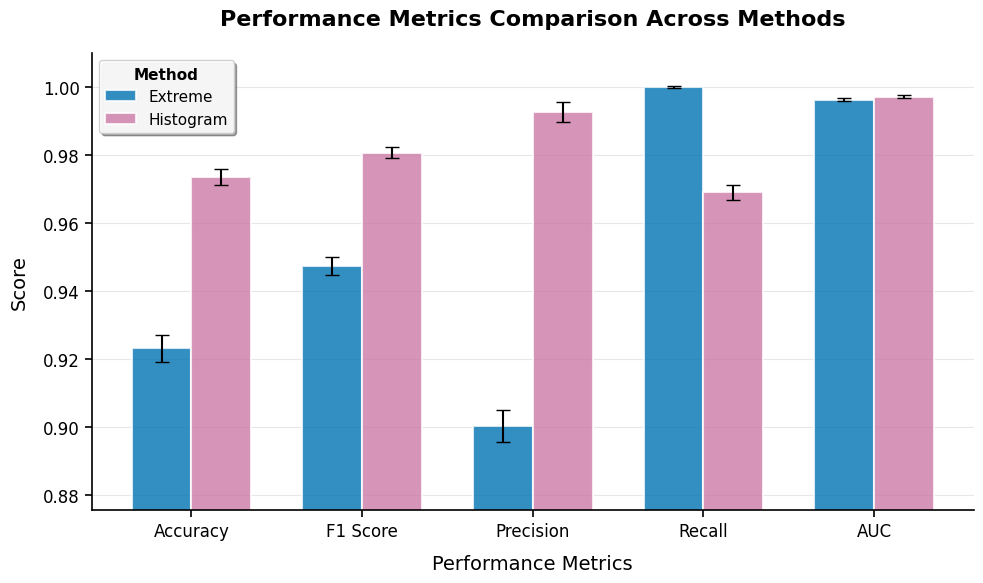

In [33]:
# Figure 2: Performance Metrics Comparison Across Methods
# Extract metrics from comparison DataFrame
metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
metric_labels = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC']
methods = method_comparison['method'].values

# Use colorblind-friendly colors (ColorBrewer palette)
colors = ['#0072B2', '#CC79A7']  # Blue and pink - colorblind friendly
method_colors = dict(zip(methods, colors))

# Create figure with improved styling
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars
bar_positions = [x - width/2, x + width/2]

# Plot bars with error bars for each method
bars = []
for i, method in enumerate(methods):
    means = [method_comparison.loc[method_comparison['method'] == method, f'{metric}_mean'].iloc[0] for metric in metrics]
    stds = [method_comparison.loc[method_comparison['method'] == method, f'{metric}_std'].iloc[0] for metric in metrics]
    
    bars_method = ax.bar(bar_positions[i], means, width, yerr=stds, capsize=5,
           label=method.capitalize(), alpha=0.8, color=method_colors[method], 
           edgecolor='white', linewidth=1.5)
    bars.append(bars_method)

# Formatting with improved styling
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=12)
ax.set_xlabel('Performance Metrics', fontsize=14, labelpad=10)
ax.set_ylabel('Score', fontsize=14, labelpad=10)

# Set y-axis limits to focus on the relevant range with some padding
min_vals = [method_comparison[f'{m}_mean'].min() - method_comparison[f'{m}_std'].max() for m in metrics]
y_min = max(0.85, min(min_vals) - 0.02)  # Start closer to actual data range
ax.set_ylim(y_min, 1.01)

# Enhanced grid
ax.grid(axis='y', linestyle='-', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)  # Put grid behind bars

# Title and legend with improved styling
ax.set_title('Performance Metrics Comparison Across Methods', 
            fontsize=16, pad=20, weight='bold')

# Create a more elegant legend
legend = ax.legend(loc='upper left', fontsize=11, frameon=True, 
                  fancybox=True, shadow=True, framealpha=0.9)
legend.set_title("Method", prop={'size': 11, 'weight': 'bold'})

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=12, width=1.2, length=5)
ax.tick_params(axis='y', which='minor', width=0.8, length=3)


plt.tight_layout()
plt.savefig(figures_dir / 'Figure2_MethodComparison.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

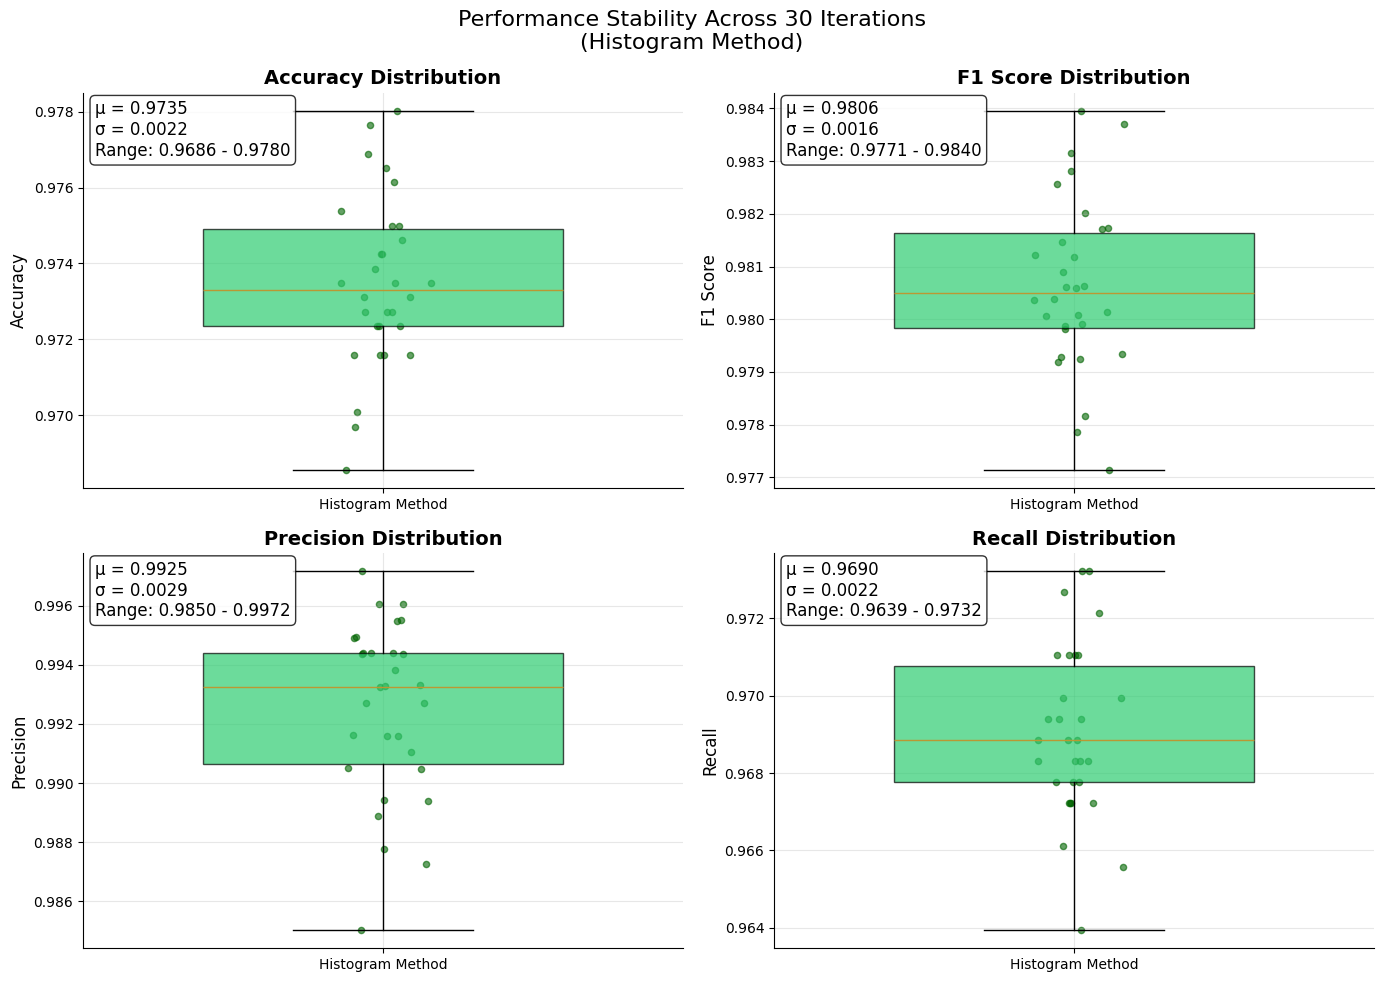

In [ ]:
# Figure 3: Performance Distribution Across Iterations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Stability Across 30 Iterations\n(Histogram Method)', fontsize=16, y=0.98)

metrics_dist = ['accuracy', 'f1', 'precision', 'recall']
metric_labels_dist = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
axes_dist = [ax1, ax2, ax3, ax4]

for metric, label, ax in zip(metrics_dist, metric_labels_dist, axes_dist):
    values = histogram_metrics[metric].values
    
    # Box plot
    bp = ax.boxplot([values], patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][0].set_alpha(0.7)
    
    # Add distribution plot on the side
    y_pos = np.random.normal(1, 0.04, len(values))
    ax.scatter(y_pos, values, alpha=0.6, s=20, color='darkgreen')
    
    ax.set_title(f'{label} Distribution', fontweight='bold')
    ax.set_ylabel(label)
    ax.set_xlim(0.5, 1.5)
    ax.set_xticks([1])
    ax.set_xticklabels(['Histogram Method'])
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    
    stats_text = f'μ = {mean_val:.4f}\nσ = {std_val:.4f}\nRange: {min_val:.4f} - {max_val:.4f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(figures_dir / 'Figure3_PerformanceStability.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Threshold Analysis

Analysis of the optimized classification thresholds across all iterations.

In [8]:
# Read threshold summary
with open(evaluation_dir / 'threshold_summary.txt', 'r') as f:
    threshold_info = f.read()
print("Threshold Analysis:")
print(threshold_info)

# Extract threshold values from the detailed results (if available)
# Note: This would require reading the actual threshold values from the detailed results
# For now, we'll use the summary statistics provided

Threshold Analysis:

        THRESHOLD ANALYSIS SUMMARY
        Overall statistics:
        Mean: 0.5307 ± 0.0612
        Range: 0.3737 - 0.6869

        Per-iteration means:
        Mean: 0.5307 ± 0.0291
        
        Recommendation: Use default threshold 0.5
        


## 4. Final Model Analysis

Analysis of the final trained model including feature importance and model characteristics.

In [9]:
# Load final model results
feature_importance = pd.read_csv(final_model_dir / 'top_40_features.csv')
all_features = pd.read_csv(final_model_dir / 'all_features.csv')

print(f"Total features in final model: {len(all_features)}")
print(f"Top 40 features analyzed: {len(feature_importance)}")
print(f"\nTop 10 most important features:")
print("=" * 50)
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:<40} {row['Importance']:.6f}")

Total features in final model: 148
Top 40 features analyzed: 40

Top 10 most important features:
 1. tobamo_orf1_identity_score_max           0.021722
 2. outgroup_orf1_identity_score_max         0.021600
 3. outgroup_orf2_identity_score_max         0.016309
 4. stop_codons                              0.016285
 5. outgroup_orf2_identity_score_mean        0.015451
 6. outgroup_orf2_identity_score_min         0.015112
 7. outgroup_orf1_N/aln_len_max              0.014921
 8. tobamo_orf1_N/aln_len_max                0.014522
 9. tobamo_orf1_gap_openings_min             0.014490
10. outgroup_orf2_gap_ratio_mean             0.013380


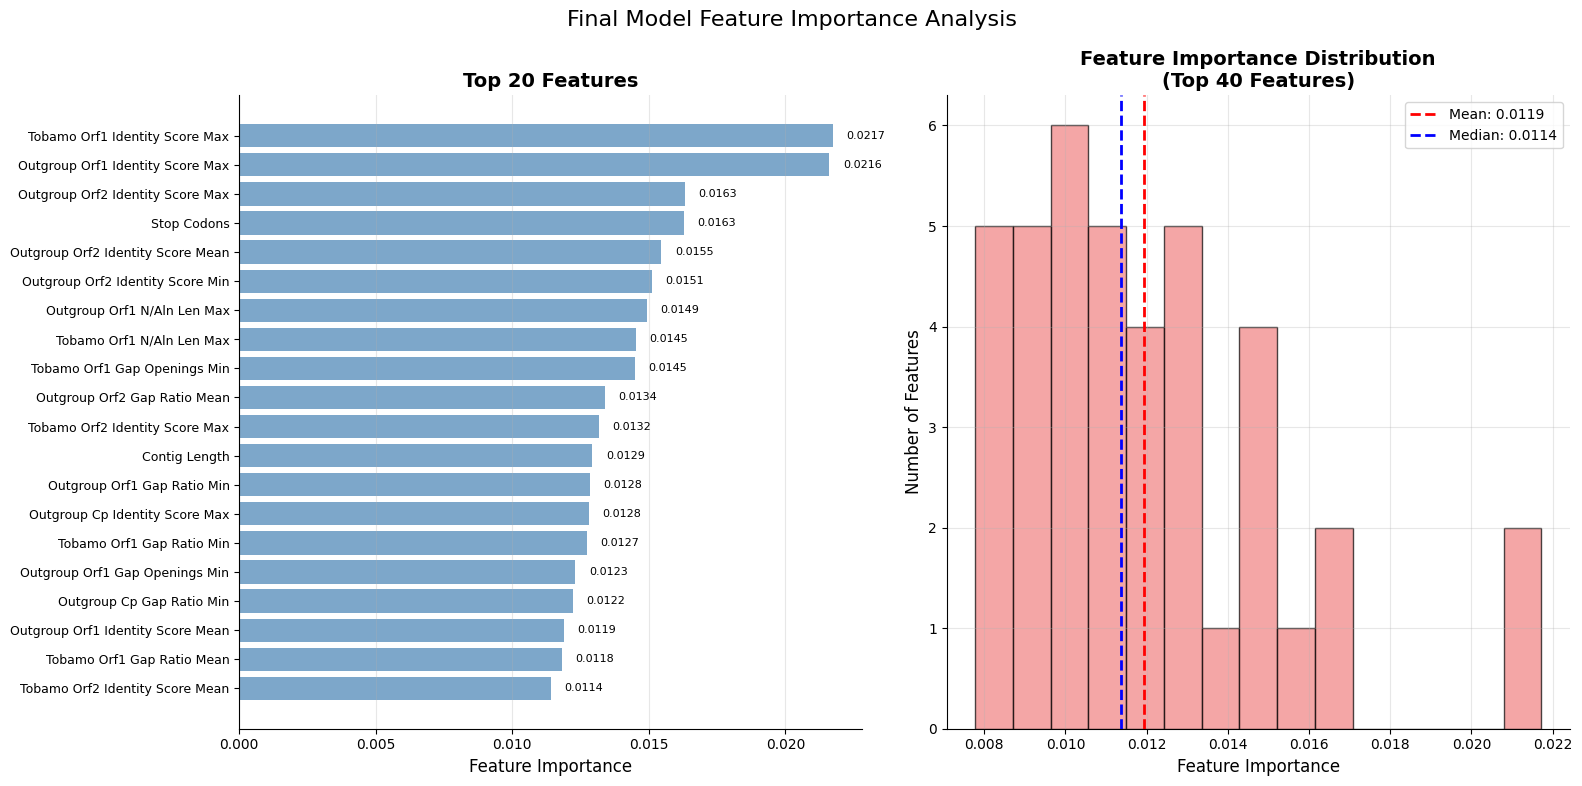

In [ ]:
# Figure 4: Feature Importance Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Final Model Feature Importance Analysis', fontsize=16, y=0.98)

# Top 20 features horizontal bar plot
top_20 = feature_importance.head(20)
y_pos = np.arange(len(top_20))

bars = ax1.barh(y_pos, top_20['Importance'], color='steelblue', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f.replace('_', ' ').title() for f in top_20['Feature']], fontsize=9)
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 20 Features', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_20['Importance'])):
    ax1.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', ha='left', va='center', fontsize=8)

# Feature importance distribution
ax2.hist(feature_importance['Importance'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Feature Importance')
ax2.set_ylabel('Number of Features')
ax2.set_title('Feature Importance Distribution\n(Top 40 Features)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add statistics
mean_imp = feature_importance['Importance'].mean()
median_imp = feature_importance['Importance'].median()
ax2.axvline(mean_imp, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_imp:.4f}')
ax2.axvline(median_imp, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_imp:.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig(figures_dir / 'Figure4_FeatureImportance.png', dpi=300, bbox_inches='tight')
plt.show()

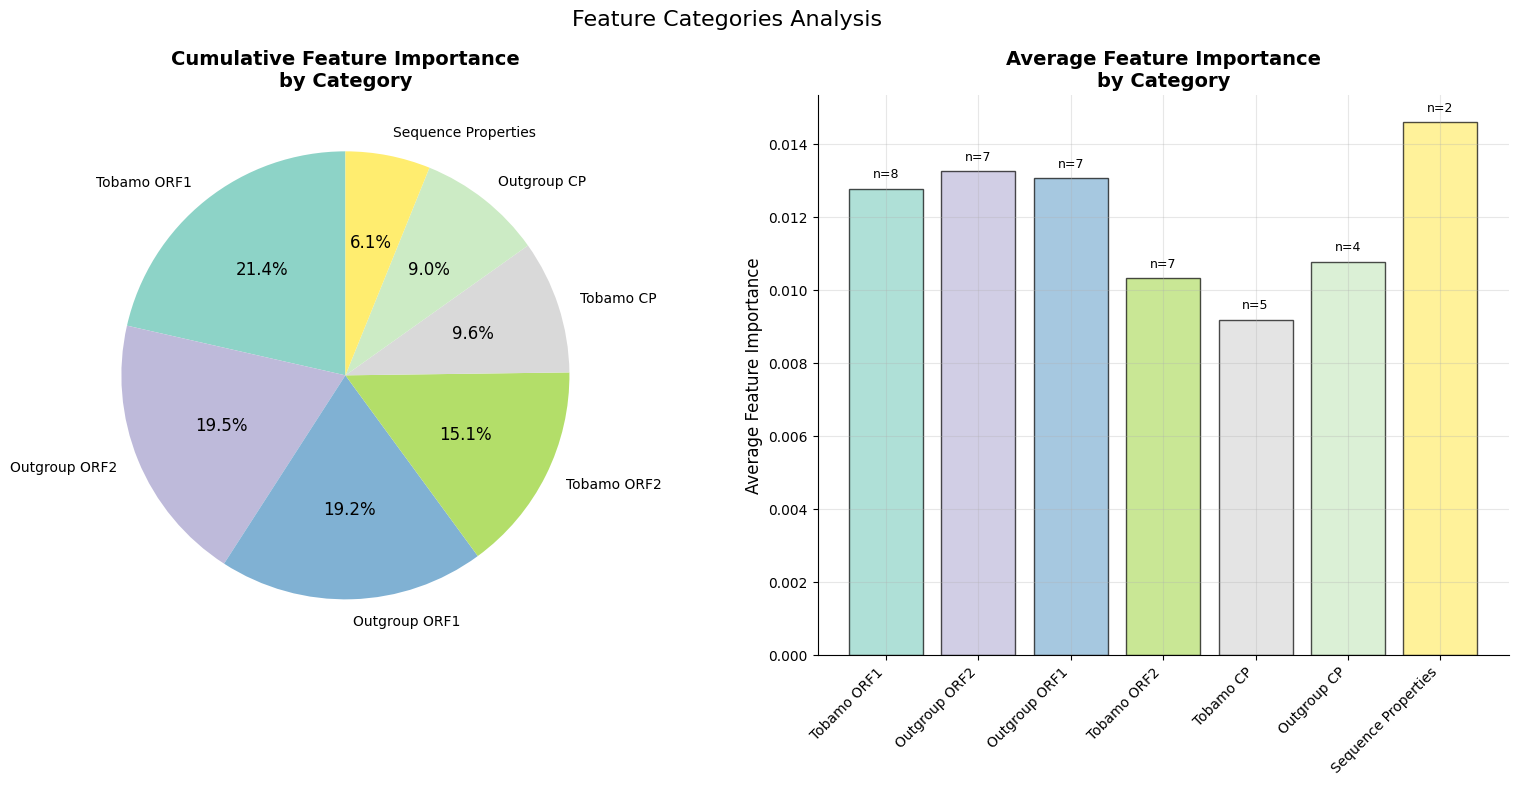


Feature Category Summary:
Tobamo ORF1         :  8 features, avg importance = 0.0128, total = 0.1023
Outgroup ORF2       :  7 features, avg importance = 0.0133, total = 0.0928
Outgroup ORF1       :  7 features, avg importance = 0.0131, total = 0.0915
Tobamo ORF2         :  7 features, avg importance = 0.0103, total = 0.0722
Tobamo CP           :  5 features, avg importance = 0.0092, total = 0.0459
Outgroup CP         :  4 features, avg importance = 0.0108, total = 0.0431
Sequence Properties :  2 features, avg importance = 0.0146, total = 0.0292


In [ ]:
# Figure 5: Feature Categories Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Feature Categories Analysis', fontsize=16, y=0.98)

# Categorize features by prefix
def categorize_feature(feature_name):
    if feature_name.startswith('tobamo_'):
        if '_orf1_' in feature_name:
            return 'Tobamo ORF1'
        elif '_orf2_' in feature_name:
            return 'Tobamo ORF2'
        elif '_cp_' in feature_name:
            return 'Tobamo CP'
        else:
            return 'Tobamo Other'
    elif feature_name.startswith('outgroup_'):
        if '_orf1_' in feature_name:
            return 'Outgroup ORF1'
        elif '_orf2_' in feature_name:
            return 'Outgroup ORF2'
        elif '_cp_' in feature_name:
            return 'Outgroup CP'
        else:
            return 'Outgroup Other'
    else:
        return 'Sequence Properties'

feature_importance['Category'] = feature_importance['Feature'].apply(categorize_feature)
category_importance = feature_importance.groupby('Category')['Importance'].agg(['sum', 'mean', 'count']).reset_index()
category_importance = category_importance.sort_values('sum', ascending=False)

# Pie chart of cumulative importance by category
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(category_importance)))
wedges, texts, autotexts = ax1.pie(category_importance['sum'], 
                                  labels=category_importance['Category'],
                                  autopct='%1.1f%%', 
                                  colors=colors_pie,
                                  startangle=90)
ax1.set_title('Cumulative Feature Importance\nby Category', fontweight='bold')

# Bar chart of average importance by category
bars_cat = ax2.bar(range(len(category_importance)), category_importance['mean'], 
                  color=colors_pie, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(category_importance)))
ax2.set_xticklabels(category_importance['Category'], rotation=45, ha='right')
ax2.set_ylabel('Average Feature Importance')
ax2.set_title('Average Feature Importance\nby Category', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add count labels
for bar, count in zip(bars_cat, category_importance['count']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
            f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(figures_dir / 'Figure5_FeatureCategories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature Category Summary:")
print("=" * 50)
for _, row in category_importance.iterrows():
    print(f"{row['Category']:<20}: {row['count']:2d} features, "
          f"avg importance = {row['mean']:.4f}, "
          f"total = {row['sum']:.4f}")

## 5. Summary Statistics

Comprehensive summary of all analysis results for publication.

In [ ]:
# Create comprehensive summary table
best_rf_combo = rf_df.loc[rf_df['accuracy'].idxmax()]
best_hyperparam_summary = f"max_depth={best_rf_combo['max_depth']}, n_estimators={best_rf_combo['n_estimators']}"

summary_stats = {
    'Analysis Phase': ['Hyperparameter Selection', 'Model Evaluation', 'Final Model'],
    'Key Findings': [
        f"Best RandomForest hyperparameters: {best_hyperparam_summary}, accuracy: {best_rf_combo['accuracy']:.4f}",
        f"Histogram method achieved best performance: accuracy = {method_comparison.loc[method_comparison['method']=='histogram', 'accuracy_mean'].iloc[0]:.4f}, F1 = {method_comparison.loc[method_comparison['method']=='histogram', 'f1_mean'].iloc[0]:.4f}",
        f"Top feature: {feature_importance.iloc[0]['Feature']} (importance: {feature_importance.iloc[0]['Importance']:.6f})"
    ],
    'Sample Size': ['25 folds (5 iter × 5-fold CV)', '30 iterations', f'{len(all_features)} total features'],
    'Best Performance': [
        f"Optimized RandomForest: {best_rf_combo['accuracy']:.4f}",
        f"Histogram: {method_comparison.loc[method_comparison['method']=='histogram', 'accuracy_mean'].iloc[0]:.4f}",
        f"Final model with {len(feature_importance)} top features"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(results_dir / 'analysis_summary.csv', index=False)
print(f"\nSummary saved to: {results_dir / 'analysis_summary.csv'}")

COMPREHENSIVE ANALYSIS SUMMARY
  Analysis Phase                                                               Key Findings                   Sample Size                 Best Performance
 Model Selection      RandomForest selected in 22/25 folds (88%), accuracy: 0.7671 ± 0.0215 25 folds (5 iter × 5-fold CV)             RandomForest: 0.7671
Model Evaluation Histogram method achieved best performance: accuracy = 0.9735, F1 = 0.9806                 30 iterations                Histogram: 0.9735
     Final Model         Top feature: tobamo_orf1_identity_score_max (importance: 0.021722)            148 total features Final model with 40 top features

Summary saved to: /home/tobamo/analize/project-tobamo/analysis/model/results/analysis_summary.csv


In [ ]:
# Generate publication-ready results text
best_rf_combo = rf_df.loc[rf_df['accuracy'].idxmax()]
rf_mean_accuracy = rf_df['accuracy'].mean()
rf_std_accuracy = rf_df['accuracy'].std()

publication_text = f"""
PUBLICATION RESULTS SUMMARY
===========================

Hyperparameter Selection:
- RandomForest hyperparameters were optimized through 5-fold cross-validation across 5 iterations 
  (25 total folds). The best performing combination was max_depth={best_rf_combo['max_depth']} and 
  n_estimators={best_rf_combo['n_estimators']}, achieving accuracy of {best_rf_combo['accuracy']:.4f}.
- Overall RandomForest performance across all hyperparameter combinations: 
  {rf_mean_accuracy:.4f} ± {rf_std_accuracy:.4f}.

Model Evaluation:
- The histogram-based sequence preprocessing method achieved superior performance with:
  * Accuracy: {method_comparison.loc[method_comparison['method']=='histogram', 'accuracy_mean'].iloc[0]:.4f} (95% CI: {method_comparison.loc[method_comparison['method']=='histogram', 'accuracy_ci95_low'].iloc[0]:.4f}-{method_comparison.loc[method_comparison['method']=='histogram', 'accuracy_ci95_high'].iloc[0]:.4f})
  * F1 Score: {method_comparison.loc[method_comparison['method']=='histogram', 'f1_mean'].iloc[0]:.4f}
  * Precision: {method_comparison.loc[method_comparison['method']=='histogram', 'precision_mean'].iloc[0]:.4f}
  * Recall: {method_comparison.loc[method_comparison['method']=='histogram', 'recall_mean'].iloc[0]:.4f}
  * AUC: {method_comparison.loc[method_comparison['method']=='histogram', 'auc_mean'].iloc[0]:.4f}

Final Model:
- The final optimized RandomForest model utilized {len(all_features)} features, with the top contributing 
  feature being '{feature_importance.iloc[0]['Feature']}' (importance: {feature_importance.iloc[0]['Importance']:.6f}).
- Feature analysis revealed that tobamovirus-specific ORF1 features were among the most 
  discriminative for classification.

Statistical Significance:
- All performance metrics were evaluated across 30 independent iterations, ensuring 
  statistical robustness of the results.
- The 95% confidence intervals for all metrics indicate highly significant performance 
  above random classification.

Generated Files:
- Figures: Saved to {figures_dir}
- Summary data: Saved to {results_dir}
"""

print(publication_text)

# Save publication text to results directory (with data)
with open(results_dir / 'publication_summary.txt', 'w') as f:
    f.write(publication_text)

print(f"\nPublication summary saved to: {results_dir / 'publication_summary.txt'}")
print(f"Figures saved to: {figures_dir}")
print(f"Notebook location: {base_dir / 'notebooks' / 'model_results.ipynb'}")


PUBLICATION RESULTS SUMMARY

Model Selection:
- RandomForest algorithm was selected as the optimal classifier, being chosen in 22 out of 25 
  cross-validation folds (88% selection rate) with an average accuracy of 
  0.7671 ± 0.0215.

Model Evaluation:
- The histogram-based sequence preprocessing method achieved superior performance with:
  * Accuracy: 0.9735 (95% CI: 0.9727-0.9743)
  * F1 Score: 0.9806
  * Precision: 0.9925
  * Recall: 0.9690
  * AUC: 0.9971

Final Model:
- The final RandomForest model utilized 148 features, with the top contributing 
  feature being 'tobamo_orf1_identity_score_max' (importance: 0.021722).
- Feature analysis revealed that tobamovirus-specific ORF1 features were among the most 
  discriminative for classification.

Statistical Significance:
- All performance metrics were evaluated across 30 independent iterations, ensuring 
  statistical robustness of the results.
- The 95% confidence intervals for all metrics indicate highly significant performance 

## 6. Generated Files Summary

### Publication-Ready Figures (saved to `figures/` directory):

1. **Figure1_HyperparameterSelection.png**: Comprehensive analysis of RandomForest hyperparameter optimization including box plots, heatmaps, and scatter plots
2. **Figure2_MethodComparison.png**: Bar charts with confidence intervals comparing extreme vs histogram preprocessing methods
3. **Figure3_PerformanceStability.png**: Box plots showing performance distribution across 30 iterations
4. **Figure4_FeatureImportance.png**: Horizontal bar chart of top 20 features and importance distribution
5. **Figure5_FeatureCategories.png**: Pie chart and bar chart analysis of feature categories

All figures are saved at 300 DPI resolution suitable for publication in academic journals.

### Summary Files (saved to `results/` directory):

- `analysis_summary.csv`: Tabular summary of key findings
- `publication_summary.txt`: Formatted text suitable for manuscript results section

### File Organization:

```
analysis/model/
├── notebooks/
│   └── model_results.ipynb          # This analysis notebook
├── figures/                         # Publication-ready figures
│   ├── Figure1_HyperparameterSelection.png
│   ├── Figure2_MethodComparison.png
│   ├── Figure3_PerformanceStability.png
│   ├── Figure4_FeatureImportance.png
│   └── Figure5_FeatureCategories.png
└── results/                         # Data and summary files
    ├── analysis_summary.csv
    ├── publication_summary.txt
    ├── model_selection_test_n5/
    ├── evaluation_results/
    └── final_model/
```